In [0]:
import numpy as np
import pandas as pd

################################## LOADING DATASET ##########################################
train_data = pd.read_csv('/RainDataset/train/train.csv', nrows=3e6)
raw_ids_all = train_data["Id"]
raw_ids = raw_ids_all.unique()
#checking Ref column for Nan valaues
train_raw_tmp = train_data[~np.isnan(train_data.Ref)]
raw_ids_tmp = train_raw_tmp["Id"].unique()
train_new = train_data[np.in1d(raw_ids_all, raw_ids_tmp)]
#fill Nan values with zero
train_new = train_new.fillna(0.0)

In [0]:
def pad_series(X, target_len=19):
    #to pad array
    seq_len = X.shape[0]
    pad_size = target_len-seq_len
    if (pad_size > 0):
        X = np.pad(X, ((0,pad_size), (0,0)), 'constant', constant_values=0.)
    return X, seq_len
  
THRESHOLD=70 #used for comparion with label values
train_new_group = train_new.groupby('Id')
df = pd.DataFrame(train_new_group['Expected'].mean())
#get valid values and remove records that has ultimate gauge readings out of the realm of possibility. 
meaningful_ids = np.array(df[df['Expected'] < THRESHOLD].index)
#getting final training set
train_final = train_new[np.in1d(train_new.Id, meaningful_ids)]
data_pd_gp = train_final.groupby("Id")
data_size = len(data_pd_gp)

In [0]:
#set the dimension 19x22
INPUT_WIDTH = 19
#declaring empty arrays for training data and its labels
X_train = np.empty((data_size, INPUT_WIDTH, 22))
seq_lengths = np.zeros(data_size)
y_train = np.zeros(data_size)
#looping through dataframe
i = 0
for _, group in data_pd_gp:
    group_array = np.array(group)
    X, seq_length = pad_series(group_array[:,1:23], target_len=INPUT_WIDTH) 
    y = group_array[0,23]
    X_train[i,:,:] = X[:,:]
    seq_lengths[i] = seq_length
    y_train[i]= y
    i += 1
    
X_train.shape, y_train.shape

((157385, 19, 22), (157385,))

In [0]:
import tensorflow as tf
#building model using keras LSTM (RNN) layer
def get_model(shape=(19,22)):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128,input_shape=shape, 
                               activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    #compiling and computing mean absolute error as loss function and adam as optimizer
    model.compile(loss='mae', optimizer='adam')
    return model

In [0]:
#build model
model = get_model()
#train the model and splitting data into training and testing dataset (20%-testing and 80% training)
h = model.fit(X_train, y_train, validation_split=0.2, epochs=15, verbose=2)

Train on 125908 samples, validate on 31477 samples
Epoch 1/15
 - 137s - loss: 2.9048 - val_loss: 2.5580
Epoch 2/15
 - 138s - loss: 2.6028 - val_loss: 2.5345
Epoch 3/15
 - 136s - loss: 2.5806 - val_loss: 2.5767
Epoch 4/15
 - 140s - loss: 2.5310 - val_loss: 2.5475
Epoch 5/15
 - 137s - loss: 2.4512 - val_loss: 2.3894
Epoch 6/15
 - 136s - loss: 2.3899 - val_loss: 2.3818
Epoch 7/15
 - 141s - loss: 2.3759 - val_loss: 2.4164
Epoch 8/15
 - 140s - loss: 2.3676 - val_loss: 2.3633
Epoch 9/15
 - 140s - loss: 2.3457 - val_loss: 2.4294
Epoch 10/15
 - 136s - loss: 2.3396 - val_loss: 2.3680
Epoch 11/15
 - 137s - loss: 2.3318 - val_loss: 2.3602
Epoch 12/15
 - 136s - loss: 2.3750 - val_loss: 2.3769
Epoch 13/15
 - 139s - loss: 2.3580 - val_loss: 2.3382
Epoch 14/15
 - 138s - loss: 2.3384 - val_loss: 2.3324
Epoch 15/15
 - 137s - loss: 2.4699 - val_loss: 2.6347


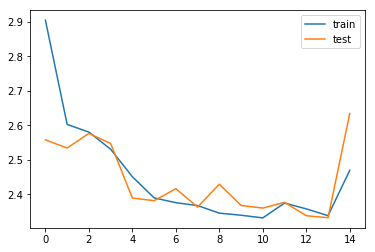

In [0]:
from matplotlib import pyplot as plt
# plot loss for both test and train
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='test')
plt.legend()
plt.show()

## **Improved Model**

In [0]:
import tensorflow as tf
#building model with two layers
def get_model_1(shape=(19,22)):
    model = tf.keras.models.Sequential()
    #setting return_sequences=true as it is used by next recurrent layer
    model.add(tf.keras.layers.LSTM(32,input_shape=shape, 
                               activation='relu',return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [0]:
#building model
model = get_model_1()
#fitting model in batches
h = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=50,verbose=2)

Train on 125908 samples, validate on 31477 samples
Epoch 1/10
 - 188s - loss: 2.4763 - val_loss: 2.3902
Epoch 2/10
 - 187s - loss: 2.3426 - val_loss: 2.3415
Epoch 3/10
 - 186s - loss: 2.3135 - val_loss: 2.3844
Epoch 4/10
 - 188s - loss: 2.3071 - val_loss: 2.3228
Epoch 5/10
 - 187s - loss: 2.2851 - val_loss: 2.2850
Epoch 6/10
 - 185s - loss: 2.2781 - val_loss: 2.2919
Epoch 7/10
 - 189s - loss: 2.2760 - val_loss: 2.2894
Epoch 8/10
 - 188s - loss: 2.2713 - val_loss: 2.3715
Epoch 9/10
 - 187s - loss: 2.2597 - val_loss: 2.3025
Epoch 10/10
 - 187s - loss: 2.2587 - val_loss: 2.3166


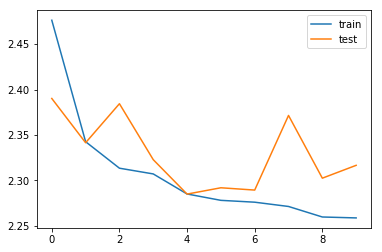

In [0]:
from matplotlib import pyplot as plt
# plot Loss of training and testing dataset
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
#getting test.csv records
test_raw = pd.read_csv('/RainDataset/test/test.csv')
test_raw_ids_all = test_raw["Id"]
#preprocess the data
test_raw_ids = np.array(test_raw_ids_all.unique())
test_new = test_raw.fillna(0.0)
#getting total data size by grouping by id
data_pd_gp = test_new.groupby("Id")
data_size = len(data_pd_gp)
#creating empty numpy array with size calculated 
X_test = np.empty((data_size, INPUT_WIDTH, 22))
seq_lengths = np.zeros(data_size)
#looping through data and padding array
i = 0
for _, group in data_pd_gp:
    group_array = np.array(group)
    X, seq_length = pad_series(group_array[:,1:23], target_len=INPUT_WIDTH) 
    X_test[i,:,:] = X[:,:]
    seq_lengths[i] = seq_length
    i += 1

In [0]:
#predicting test data
output = model.predict(X_test, batch_size=32,verbose=1)
#creating submission file
my_submission = pd.DataFrame({'Id': np.arange(1,output.shape[0]+1), 'Expected': output[:,0]})
my_submission.to_csv('/RainDataset/mySubmissionFile.csv', index=False)
print('.csv file generated successfully!')

717625/717625 [==============================] - 315s 439us/sample
.csv file generated successfully!


## **SimpleRNN**

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import Dense
#features to extract
max_features=1000
model = Sequential()
#building model using SimpleRNN
model.add(SimpleRNN(64, activation='relu',input_shape = ((19,22))))
model.add(Dense(1, activation='sigmoid'))
#compiling model
model.compile(optimizer='adam', loss='mae')
#training model
history=model.fit(X_train, y_train, validation_split=0.2, epochs=10, verbose=2)

Train on 125908 samples, validate on 31477 samples
Epoch 1/10
 - 49s - loss: 2.6673 - val_loss: 2.7612
Epoch 2/10
 - 50s - loss: 2.6567 - val_loss: 2.7407
Epoch 3/10
 - 48s - loss: 2.6549 - val_loss: 2.7322
Epoch 4/10
 - 49s - loss: 2.6599 - val_loss: 2.7726
Epoch 5/10
 - 49s - loss: 2.6857 - val_loss: 2.7650
Epoch 6/10
 - 48s - loss: 2.6805 - val_loss: 2.7838
Epoch 7/10
 - 49s - loss: 2.7023 - val_loss: 2.7837
Epoch 8/10
 - 50s - loss: 2.7023 - val_loss: 2.7842
Epoch 9/10
 - 48s - loss: 2.6820 - val_loss: 2.7688
Epoch 10/10
 - 49s - loss: 2.6821 - val_loss: 2.7819


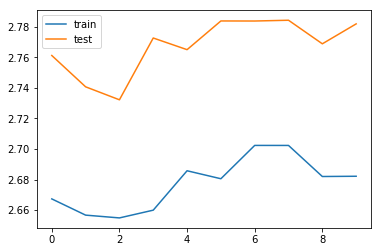

In [0]:
from matplotlib import pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **Using Bi-directional**

In [0]:
############### importing libraries ################
from keras.layers import (
    Input,
    Dense,
    LSTM,
    AveragePooling1D,
    TimeDistributed,
    Flatten,
    Bidirectional,
    Dropout
)
from keras.models import Model
#building model
def get_model2(shape=(19, 22)):
    inp = Input(shape)
    x = Dense(16)(inp)
    #Bidirectional layer connects two hidden layer in opposite direction
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    #allows you to apply that Dense function across every output over time
    x = TimeDistributed(Dense(128))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = TimeDistributed(Dense(1))(x)
    #pooling using average method
    x = AveragePooling1D()(x)
    x = Flatten()(x)
    #using dropout layer
    x = Dropout(0.3)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 100
N_EPOCHS = 10
#using earlystopping if no improvment observed
#ReduceLROnPlateau to update the learning rate by factor 0.1
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_delta=0.01)
#building model
model = get_model2((19,22))
#comiling model
model.compile(optimizer='adam', loss='mae',)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 19, 22)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            368       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 19, 256)           148480    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 128)           32896     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 19, 256)           263168    
_________________________________________________________________
time_distributed_2 (T

In [0]:
#training model in batches
h=model.fit(X_train, y_train, 
            batch_size=BATCH_SIZE, epochs=N_EPOCHS, 
            validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Train on 125908 samples, validate on 31477 samples
Epoch 1/10
125908/125908 [==============================] - 167s 1ms/step - loss: 2.4398 - val_loss: 2.2976
Epoch 2/10
125908/125908 [==============================] - 163s 1ms/step - loss: 2.3431 - val_loss: 2.3628
Epoch 3/10
125908/125908 [==============================] - 163s 1ms/step - loss: 2.3159 - val_loss: 2.2913
Epoch 4/10
125908/125908 [==============================] - 163s 1ms/step - loss: 2.3041 - val_loss: 2.2704
Epoch 5/10
125908/125908 [==============================] - 165s 1ms/step - loss: 2.2934 - val_loss: 2.2744
Epoch 6/10
125908/125908 [==============================] - 165s 1ms/step - loss: 2.2825 - val_loss: 2.2804
Epoch 7/10
125908/125908 [==============================] - 163s 1ms/step - loss: 2.2683 - val_loss: 2.2904
Epoch 8/10
125908/125908 [==============================] - 160s 1ms/step - loss: 2.2150 - val_loss: 2.2354
Epoch 9/10
125908/125908 [===========

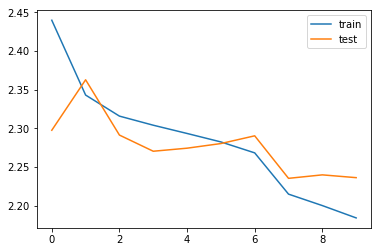

In [0]:
from matplotlib import pyplot as plt
# plot loss for training and testing dataset
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='test')
plt.legend()
plt.show()